In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import gym
from gym import spaces
from gym.spaces import Box, Discrete
from collections import deque
import itertools
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler
import warnings
import os
import pickle
warnings.filterwarnings("ignore")

# create random number generator
rng = np.random.default_rng()

In [2]:
def get_data(name):
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv(name)
  return df.values    # get a numpy array
                      # each row corresponds to the same day, from Feb 2013 - Feb 2018

# 1st Split

In [3]:
train_1st = get_data("UltimateStocks.csv")[:-440]
train_1st

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

In [4]:
test_1st = get_data("UltimateStocks.csv")[-440:]
test_1st

array([[190.039992, 108.75    ,  57.650002],
       [188.589996, 108.370003,  57.27    ],
       [188.149992, 107.379997,  57.130001],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

# 2nd split

In [5]:
train_2nd = get_data("train_2nd.csv")
train_2nd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [6]:
test_2nd = get_data("test_2nd.csv")
test_2nd

array([[108.      ,  74.28    ,  55.62    ],
       [107.93    ,  75.52    ,  55.47    ],
       [108.18    ,  74.54    ,  55.47    ],
       ...,
       [185.160004, 107.309998,  57.450001],
       [186.050004, 107.839996,  57.669998],
       [187.36    , 105.779999,  57.040001]])

# 3rd split

In [7]:
train_3rd = get_data("train_3rd.csv")
train_3rd

array([[ 67.8542  ,  60.3     ,  28.185   ],
       [ 68.5614  ,  60.9     ,  28.07    ],
       [ 66.8428  ,  60.83    ,  28.13    ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [8]:
test_3rd = get_data("test_3rd.csv")
test_3rd

array([[108.83 ,  63.94 ,  38.825],
       [109.7  ,  63.55 ,  38.865],
       [111.25 ,  63.7  ,  38.925],
       ...,
       [107.48 ,  73.5  ,  55.9  ],
       [108.37 ,  73.93 ,  55.36 ],
       [108.81 ,  74.28 ,  55.2  ]])

# 4th split

In [9]:
train_4th = get_data("train_4th.csv")
train_4th

array([[108.7     ,  63.42    ,  38.725   ],
       [109.01    ,  64.14    ,  38.895   ],
       [108.83    ,  63.94    ,  38.825   ],
       ...,
       [321.450012, 176.690002,  87.559998],
       [325.209992, 178.929993,  86.150002],
       [320.03    , 179.460007,  86.419998]])

In [10]:
test_4th = get_data("test_4th.csv")
test_4th

array([[ 67.8542,  60.3   ,  28.185 ],
       [ 68.5614,  60.9   ,  28.07  ],
       [ 66.8428,  60.83  ,  28.13  ],
       ...,
       [109.4   ,  64.68  ,  38.05  ],
       [108.6   ,  66.76  ,  38.355 ],
       [108.86  ,  64.46  ,  38.33  ]])

In [11]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here
  # To get parameter for the scaler, we must have some data
  # --> play an episode randomly and store each of the states we encounter. No need for an agent
  # For more accurate, run multiple episodes

  states = []
  for _ in range(env.n_step):
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    states.append(state)
    if terminated:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler


In [12]:
class MultiStockEnv(gym.Env):

  def __init__(self, data, initial_investment=20000):             # data = return of get_data()
    # data                                                        # get_data() returns a numpy array
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape    # (# day, 3)

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price_last2 = None
    self.stock_price_yesterday = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = Discrete(343)
    self.action_list = list(map(list, itertools.product([-1, -2/3, -1/3, 0, 1/3, 2/3, 1], repeat=self.n_stock)))
                                               # -1 = sell all stocks
                                               # 0 = hold
                                               # 1 = buy with all of our money

    # calculate size of state
    self.state_dim = self.n_stock * 4 + 1      # If we have N stocks, the state contains 4N+1 dimensions

    self.reset()


  def reset(self):
    self.cur_step = 2                                                         # 3rd day of stock prices
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price_last2 = self.stock_price_history[self.cur_step - 2]      # Stock price of each stock on the last two day
    self.stock_price_yesterday = self.stock_price_history[self.cur_step - 1]  # Stock price of each stock yesterday
    self.stock_price = self.stock_price_history[self.cur_step]                # Stock price of each stock on the current day
    self.cash_in_hand = self.initial_investment                 # Not yet buy any stock, only initial investment
    return self._get_obs()                                      # Return the first state vector, done by get_obs()
                                                    # [0, 0, 0, 67.8542, 60.3, 28.185, 
                                                    #           68.5614, 60.9, 28.07, 
                                                    #           66.8428, 60.83, 28.13, 20000])



  def step(self, action):
    # assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1

    self.stock_price = self.stock_price_history[self.cur_step]    # day -> next day, price -> price for next day
                                                                  # self.stock_price_history = data = train_data -- a numpy array
    self.stock_price_last2 = self.stock_price_history[self.cur_step - 2]      # Stock price on the last two day
    self.stock_price_yesterday = self.stock_price_history[self.cur_step - 1]  # Stock price yesterday
    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val 
    # done if we have run out of data
    terminated = self.cur_step == self.n_step - 1             # True when we reach the end of the series
                                                        # Realistically, stock markets never end, there is no termination
                                                        # In here, our code ends when there is no more data
    # store the current value of the portfolio here
    info = {'cur_val': cur_val}


    # conform to the Gym API
    return self._get_obs(), reward, terminated, False, info



  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned                              # List of 3, stock owned

    obs[self.n_stock:2*self.n_stock] = self.stock_price_last2          # List of 3, stock price
    obs[2*self.n_stock:3*self.n_stock] = self.stock_price_yesterday    # List of 3, stock price
    obs[3*self.n_stock:4*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand                                        # Cash in hands for last index
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand    # Total money



  def _trade(self, action):
    action_vec = self.action_list[action]     # returns a list of size 3

    # determine which stocks to buy or sell, we need this so that we can always buy before selling
    sell_info = [] # stores index and portion of stocks we want to sell
    buy_info = []  # stores index and portion of stocks we want to buy
        
    for i, a in enumerate(action_vec):   
      if a < 0:
        sell_info.append([i,a])      # gonna sell
        
      elif a > 0:
        buy_info.append([i,a])       # gonna buy
    # print('buy_info', buy_info)
    # print('sell_info', sell_info)
    

    # Buy before sell so that the money got from selling is only available in the next time-step
    if buy_info:
      new_action = []           # to store the actions only, which do not necessarily sum to 1 
      for (i,a) in buy_info: 
        new_action.append(a)
      
      if np.sum(new_action) > 1:        # Only softmax when their sum > 1
        new_buy = softmax(new_action)   # softmax so they sum to 1
      else:
        new_buy = new_action            # Keep the old action

      for i in range(len(buy_info)):
        buy_info[i][1] = new_buy[i]     # overwriting buy_info with our new softmaxed actions, or not
      # print(buy_info)
    

      total_cash_spent = 0                             # Need this so that we only subtract when we finish buying all stocks, to prevent overwriting self.cash_in_hand
      for (i,a) in buy_info:                           # If we buy, we buy using a% of our cash_in_hand
        cash_to_spend = self.cash_in_hand*a           
        if cash_to_spend > self.stock_price[i]:          # Check if we can afford at least 1 stock
          stock_bought = cash_to_spend // self.stock_price[i]
          self.stock_owned[i] += stock_bought
          cash_spent = stock_bought * self.stock_price[i]
          total_cash_spent += cash_spent
      total_cash_spent += total_cash_spent*0.0001   # 0.01% trade fee
      self.cash_in_hand -= total_cash_spent


    # Sell after buy
    if sell_info:                                   # [] - empty list also treated as None
      for (i,a) in sell_info:                       # If we sell, we sell a% of our stock_owned 
        stock_sold = -int(self.stock_owned[i]*a)    # minus because a is negative
        # print(stock_sold)
        self.stock_owned[i] -= stock_sold
        cash_increase = self.stock_price[i] * stock_sold
        self.cash_in_hand += cash_increase - cash_increase*0.0001  # 0.01% trade fee
     

___

# 1st Split

7825.475938796624


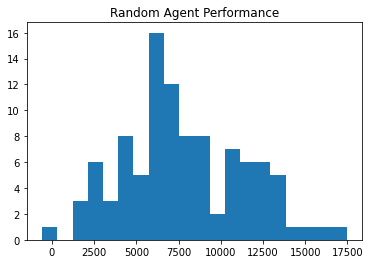

In [29]:
# Histogram to observe overall performance of 100 random agents

data = test_1st

env = MultiStockEnv(data)
total_rewards = []
for i in range(100):
    # visualise one episode
    state = env.reset()

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0
    while not (terminated or truncated):
        # take action based on policy    
        action = env.action_space.sample()
        
        # environment receives the action and returns:
        # next observation, reward, terminated, truncated, and additional information (if applicable)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
    total_rewards.append(total_reward)
plt.hist(total_rewards, bins=20)
plt.title("Random Agent Performance")

print(np.mean(total_rewards))

    # val = info['cur_val']
    # print(f'Reward: {total_reward}, info: {val}')


In [22]:
# Test 1 randomly agent to plot
data = test_1st

env = MultiStockEnv(data)
total_rewards = []

# visualise one episode
state = env.reset()

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []
while not (terminated or truncated):
    # take action based on policy    
    action = env.action_space.sample()
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)
total_reward


5092.25348019231

In [24]:
a = np.array(portfolio)
np.save('npy/Random_Test1.npy', a)

___

# 2nd Split

4359.408665611765


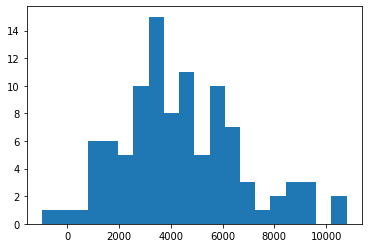

In [30]:
# Histogram to observe overall performance of 100 random agents


data = test_2nd

env = MultiStockEnv(data)
total_rewards = []
for i in range(100):
    # visualise one episode
    state = env.reset()

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0
    while not (terminated or truncated):
        # take action based on policy    
        action = env.action_space.sample()
        
        # environment receives the action and returns:
        # next observation, reward, terminated, truncated, and additional information (if applicable)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
    total_rewards.append(total_reward)
plt.hist(total_rewards, bins=20)

print(np.mean(total_rewards))


In [31]:
data = test_2nd

env = MultiStockEnv(data)
total_rewards = []

# visualise one episode
state = env.reset()

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []
while not (terminated or truncated):
    # take action based on policy    
    action = env.action_space.sample()
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)
total_reward


2284.8481217519075

In [32]:
a = np.array(portfolio)
np.save('npy/Random_Test2.npy', a)

___

# 3rd Split

2004.361168480003


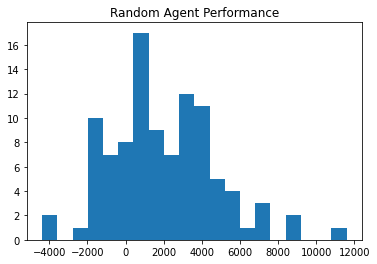

In [31]:
# Histogram to observe overall performance of 100 random agents


data = test_3rd

env = MultiStockEnv(data)
total_rewards = []
for i in range(100):
    # visualise one episode
    state = env.reset()

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0
    while not (terminated or truncated):
        # take action based on policy    
        action = env.action_space.sample()
        
        # environment receives the action and returns:
        # next observation, reward, terminated, truncated, and additional information (if applicable)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
    total_rewards.append(total_reward)
plt.hist(total_rewards, bins=20)
plt.title("Random Agent Performance")

print(np.mean(total_rewards))


In [33]:
# Test 1 random agent to plot

data = test_3rd

env = MultiStockEnv(data)
total_rewards = []

# visualise one episode
state = env.reset()

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []
while not (terminated or truncated):
    # take action based on policy    
    action = env.action_space.sample()
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)
total_reward


-348.9258297500164

In [34]:
a = np.array(portfolio)
np.save('npy/Random_Test3.npy', a)

___

# 4th Split

3976.7483757030986


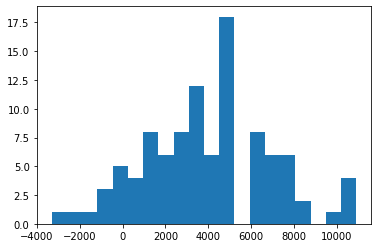

In [47]:
# Histogram to observe overall performance of 100 random agents

data = test_4th

env = MultiStockEnv(data)
total_rewards = []
for i in range(100):
    # visualise one episode
    state = env.reset()

    terminated = False
    truncated = False
    steps = 0
    total_reward = 0
    while not (terminated or truncated):
        # take action based on policy    
        action = env.action_space.sample()
        
        # environment receives the action and returns:
        # next observation, reward, terminated, truncated, and additional information (if applicable)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
    total_rewards.append(total_reward)
plt.hist(total_rewards, bins=20)


print(np.mean(total_rewards))

In [35]:
# Test 1 random agent to plot


data = test_4th

env = MultiStockEnv(data)
total_rewards = []

# visualise one episode
state = env.reset()

terminated = False
truncated = False
steps = 0
total_reward = 0
portfolio = []
while not (terminated or truncated):
    # take action based on policy    
    action = env.action_space.sample()
    
    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    asset = info['cur_val']
    portfolio.append(asset)
total_reward


4007.5142840300105

In [36]:
a = np.array(portfolio)
np.save('npy/Random_Test4.npy', a)